In [4]:
import pandas as pd
import numpy as np
from plotnine import *
import datetime
import tidypolars as tp
from tidypolars import col

import warnings
warnings.filterwarnings('ignore')

## Data to import

In [ ]:
nga_cases = pd.read_csv("https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/line_lists/line-list-nigeria.csv")
nga_admpop_1 = pd.read_csv("data/nga_admpop_adm1_2020.csv")

### Adjustments to cases data

In [5]:
# add count column to sum
nga_cases['count'] = 1

# replace 'Abuja' with 'Federal Capital Territory' to match map data state names
nga_cases['province/state'][nga_cases['province/state'] == 'Abuja'] = 'Federal Capital Territory'

## Get totals by state and date

In [6]:
# select columns & group by date + state
state_case_dates = (
    tp.from_pandas(nga_cases)
    .select('date', 'province/state', 'count')
    .summarize(total_cases = tp.sum(col('count')),
               by = ['date', 'province/state'])
)

state_case_dates = state_case_dates.to_pandas()

# state_case_dates_plot = state_case_dates.rename(columns = {'province/state':'state'})
# state_case_dates_plot['date'] = pd.to_datetime(state_case_dates_plot['date'])

# # plot cases by date
# (ggplot(state_case_dates_plot, aes('date', 'total_cases'))
#  + geom_smooth(color = 'blue')
#  + geom_col(alpha = 0.7)
#  + ggtitle('Total COVID Cases by State')
#  + theme_minimal()
#  + theme(axis_text_x = element_text(rotation=90),
#         figure_size = (8,12))
#  + facet_wrap('~state'))

## Reformat population data

In [7]:
nga_admpop_1 = pd.read_csv("data/nga_admpop_adm1_2020.csv")
nga_admpop_1.head()

# group and summarise with tp
adm1_sel = (
    tp.from_pandas(nga_admpop_1)
    .select('ADM1_NAME', 'F_TL', 'M_TL')
    .summarize(F_TL = tp.sum(col('F_TL')),
               M_TL = tp.sum(col('M_TL')),
               by = 'ADM1_NAME')
).to_pandas()

# # group and summarise with tp
# adm1_ttl = (
#     tp.from_pandas(nga_admpop_1)
#     .select('ADM1_NAME', 'T_TL')
#     .summarize(T_TL = tp.sum(col('T_TL')),
#                by = 'ADM1_NAME')
# ).to_pandas()

# adm1 = pd.melt(adm1_sel, id_vars='ADM1_NAME', value_vars=['F_TL', 'M_TL'])

# adm1_plot = (ggplot(adm1, aes('variable', 'value'))
#  + geom_col(aes(fill='variable'))
#  + ggtitle('Male vs. Female cases by region')
#  + theme_minimal()
#  + theme(axis_text_x = element_text(rotation=90),
#         figure_size = (15,20))
#  + facet_wrap('~ADM1_NAME'))

# adm1_plot

## Create state name lookup

In [8]:
# group and summarise with tp
adm1_plot = (
    tp.from_pandas(nga_admpop_1)
    .select('ADM1_PCODE', 'T_TL')
    .summarize(T_TL = tp.sum(col('T_TL')),
               by = 'ADM1_PCODE')
)

adm1_plot = adm1_plot.to_pandas()
adm1_plot.rename(columns = {'ADM1_PCODE':'admin1Pcode', 'T_TL':'population'}, inplace = True)

# create adm1 lookup
adm_lkp = (
    tp.from_pandas(nga_admpop_1)
    .select('ADM1_NAME', 'ADM1_PCODE')
)

adm_lkp = adm_lkp.to_pandas()

## Combine cases, population and location data

In [9]:
# group and summarise with tp
state_case_sel = (
    tp.from_pandas(state_case_dates)
    .select('date', 'province/state', 'total_cases')
)

state_case_sel = state_case_sel.to_pandas()
state_case_sel['ADM1_NAME'] = state_case_sel['province/state'].str.upper()
state_case_sel = state_case_sel.drop('province/state', axis=1)
state_case_sel['date'] = pd.to_datetime(state_case_sel['date'])

# state_case_sel.head()

state_cases = state_case_sel.merge(adm_lkp, on = "ADM1_NAME", how='left').drop('ADM1_NAME', axis=1)

state_cases.rename(columns = {'ADM1_PCODE':'admin1Pcode'}, inplace = True)


In [10]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

## Static Map

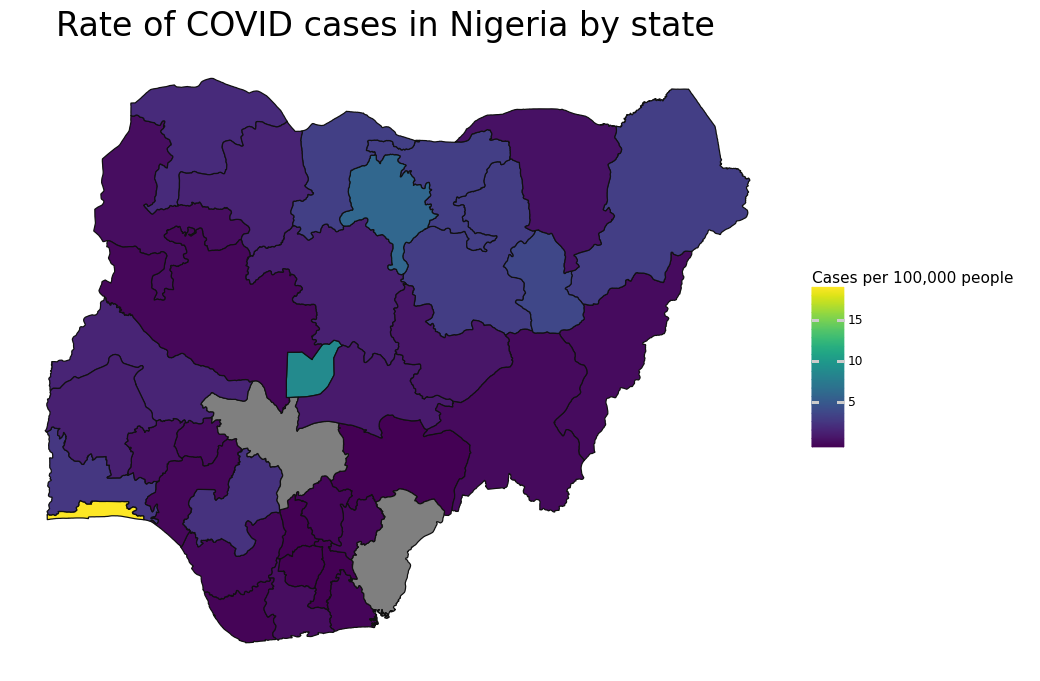

<ggplot: (92158926418)>

In [11]:
states_file = "docs/content/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

# geopandas included map, filtered to just Nigeria
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]

state_cases_sum = (
    tp.from_pandas(state_cases)
    .summarize(total_cases = tp.sum(col('total_cases')),
              by = 'admin1Pcode')
)

state_cases_sum = state_cases_sum.to_pandas()

layers = fiona.listlayers(states_file)
zones_gdf = gpd.read_file(states_file, layer=1)
zones_gdf = zones_gdf.merge(adm1_plot, on='admin1Pcode', how='left')
zones_gdf = zones_gdf.merge(state_cases_sum, on='admin1Pcode', how='left')
zones_gdf['case_rate'] = zones_gdf['total_cases'] / zones_gdf['population'] * 100000
zones_gdf.crs = "EPSG:4326"
zones_gdf = zones_gdf.set_index('admin1Name_en')

(ggplot(zones_gdf)
 + geom_map(zones_gdf, aes(fill = 'case_rate'))
 + ggtitle('Rate of COVID cases in Nigeria by state')
 + labs(fill = 'Cases per 100,000 people')
 + theme_minimal()
 + coord_fixed()
 + theme(axis_text = element_blank(),
         panel_grid = element_blank(),
         plot_title = element_text(size=24),
        figure_size = (10,12)))

## Animated map

In [12]:
from plotnine.animation import PlotnineAnimation
from matplotlib import animation

# for animation in the notebook
from matplotlib import rc
rc('animation', html='html5')

# Parameters used to control the spiral
n = 82
kmin = 0
kmax = 82
num_frames = 164

states_file = "docs/content/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

# geopandas included map, filtered to just Nigeria
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]
# base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))

def plot(k):
    # For every plot we change the theta
    state_cases['date'] = pd.to_datetime(state_cases['date'])
    
    _date = min(state_cases['date']) + pd.DateOffset(k.round(decimals=0))
    
    states = state_cases[state_cases['date'] <= pd.to_datetime(_date)]
    
    states_sum = (
    tp.from_pandas(states)
    .summarize(total_cases = tp.sum(col('total_cases')),
               by='admin1Pcode')
        )
    
    states_sum = states_sum.to_pandas()
    
    layers = fiona.listlayers(states_file)
    zones_gdf = gpd.read_file(states_file, layer=1)
    zones_gdf = zones_gdf.merge(adm1_plot, on='admin1Pcode', how='left')
    zones_gdf = zones_gdf.merge(states_sum, on='admin1Pcode', how='left')
    zones_gdf['case_rate'] = zones_gdf['total_cases'] / zones_gdf['population']
    zones_gdf.crs = "EPSG:4326"
    zones_gdf = zones_gdf.set_index('admin1Name_en')

    nga_anim = zones_gdf.copy()

    p = (ggplot(nga_anim)
 + geom_map(nga_anim, aes(fill = 'total_cases'))
 + ggtitle('Total COVID Cases by state')
 + scale_fill_continuous(limits=(0, 500))
 + labs(fill = 'Total_Cases')
 + theme_minimal()
 + coord_fixed()
 + theme(axis_text = element_blank(),
         panel_grid = element_blank(),
         plot_title = element_text(size=24),
        figure_size = (10,12)))
    
    return p

# It is better to use a generator instead of a list
plots = (plot(k) for k in np.linspace(kmin, kmax, num_frames))
ani = PlotnineAnimation(plots, interval=100, repeat_delay=500)
# ani.save('animation.gif')
ani

# writergif = animation.PillowWriter(fps=30)
# ani.save('animation.gif',writer=writergif)